In [1]:
# import basics
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import progressbar

# import custom
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))
from sscode.config import default_evaluation_metrics
from sscode.data import load_moana_hindcast
from sscode.validation import generate_stats
from sscode.plotting.validation import plot_stats
from sscode.plotting.utils import get_n_colors, plot_ccrs_nz

DATA PATH /home/javitausia/Documentos/geocean-nz-ss/data


In [2]:
# load results
linear = xr.open_dataset('../data/statistics/experiments/experiment_linear_final_20211113.nc')
knn = xr.open_dataset('../data/statistics/experiments/experiment_knn_final_20211118.nc')
xgboost = xr.open_dataset('../data/statistics/experiments/experiment_xgboost_final_20211119.nc')
mdarbf = xr.open_dataset(
    '../data/statistics/experiments/experiment_mdarbf_shores_1D_local_winds_grad_25_10_1500.nc')

In [3]:
# load all coast results
linear_all = xr.open_dataset('../data/statistics/experiments/linear_superfinal.nc')
knn_all = xr.open_dataset('../data/statistics/experiments/knn_superfinal.nc')
xgboost_all = xr.open_dataset('../data/statistics/experiments/xgboost_superfinal.nc')
xgboost_play = xr.open_dataset('../data/statistics/experiments/xgboost_superfinal_play.nc')

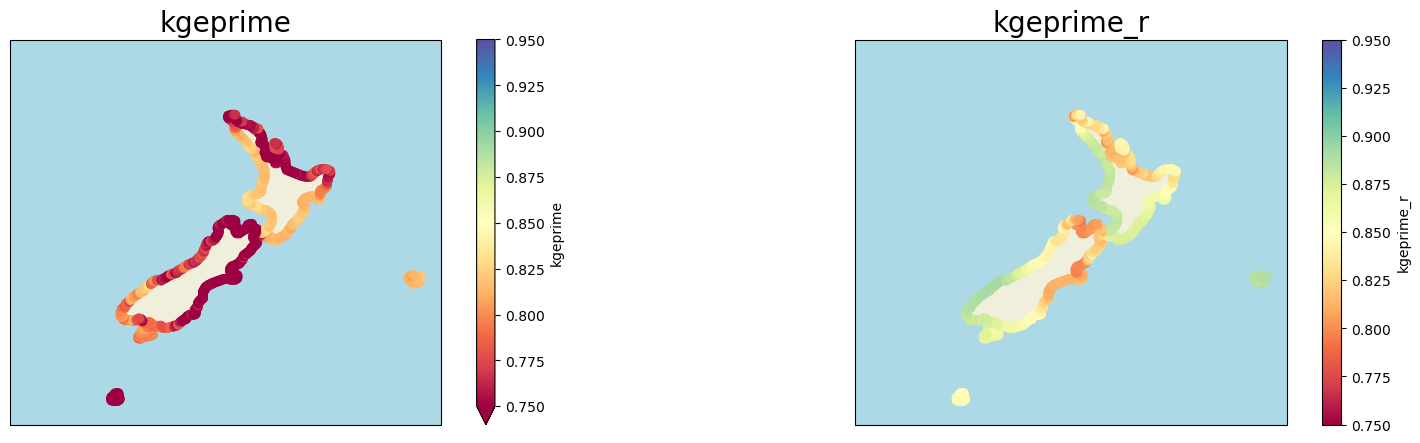

In [4]:
from sscode.data import load_moana_hindcast
from sscode.plotting.validation import plot_stats
data_plot = linear_all.isel(grad=0,perpcs=0,region=0,tlapse=0,tresample=0,winds=0,tsize=0).copy()
data_plot = data_plot.assign({
    'longitude': (('site'),load_moana_hindcast().isel(
    site=data_plot.site).lon.values)
})
data_plot = data_plot.assign({
    'latitude': (('site'),load_moana_hindcast().isel(
    site=data_plot.site).lat.values)
})
plot_stats(data_plot,plot_stats=['kgeprime','kgeprime_r'],vmin=0.75,vmax=0.95,cmap='Spectral')

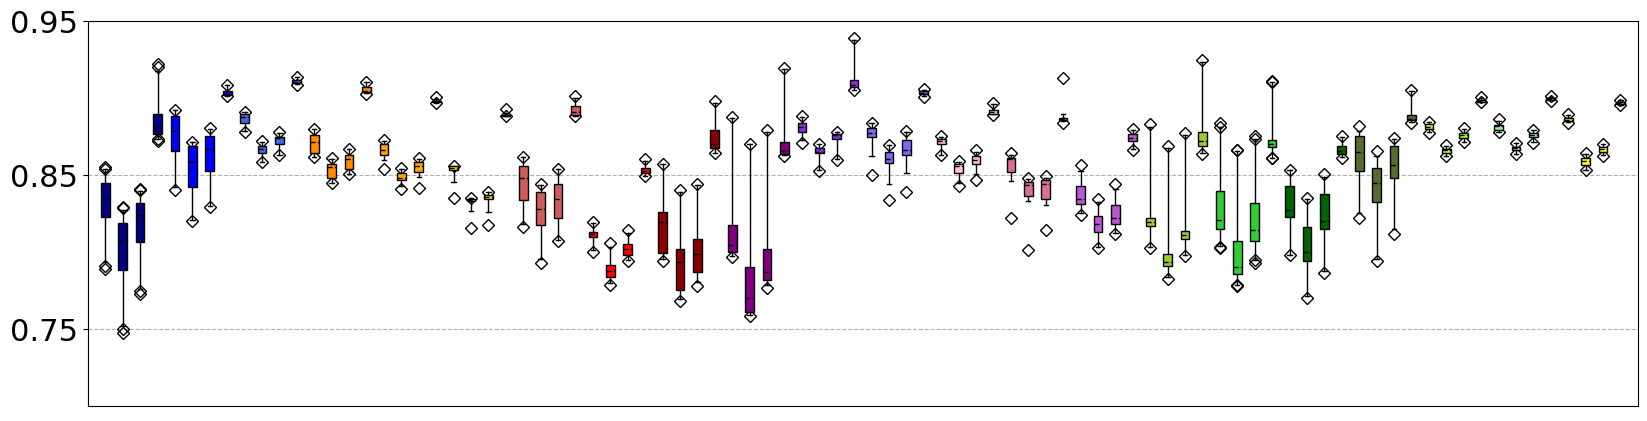

In [5]:
# load the sites in each shore
shore_sites = np.load('../data/statistics/shore_sites_last.npy',allow_pickle=True)
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

# make the boxplots
fig, ax = plt.subplots(figsize=(20,5))
for idata,data in enumerate([
    linear_all.isel(
        grad=0,perpcs=0,region=0,tlapse=0,tresample=0,winds=0,tsize=0
    ),
    knn_all.isel(
        grad=0,perpcs=0,region=0,tlapse=0,tresample=0,winds=0,tsize=0
    ).max(dim=['k_neighbors']),
    xgboost_all.isel(
        grad=0,perpcs=0,region=0,tlapse=0,tresample=0,winds=0,tsize=0,n_est=0,lr=0,loss=0
    ).max(dim=['md','mss']),
    mdarbf # this is prepared
]):
    box = ax.boxplot(
        [data.sel(site=shore_sites[i]).pearson.values for i in range(len(shore_sites))],
        patch_artist=True, sym='D', vert=True, whis=[1,99], widths=0.25, 
        medianprops={'c':'k','lw':1,'ls':'--'}, positions=np.arange(1,45,2)+0.5*idata
    ) if idata!=3 else ax.boxplot(
        [data.sel(shore=i).pearson.max(dim='experiment').values \
         for i in range(len(np.unique(data.shore.values)))],
        patch_artist=True, sym='D', vert=True, whis=[1,99], widths=0.25, 
        medianprops={'c':'k','lw':1,'ls':'--'}, positions=np.arange(1,45,2)+0.5*idata
    )
    loc_colors = [
        'navy','blue','royalblue','darkorange','orange','gold','indianred','red','darkred',
        'purple','blueviolet','mediumslateblue','pink','palevioletred','mediumorchid',
        'yellowgreen','limegreen','darkgreen','darkolivegreen','greenyellow','lightgreen','yellow'
    ]
    for patch, color in zip(box['boxes'], loc_colors):
        patch.set_facecolor(color)
    ax.set_xticks([])
    ax.set_ylabel('',fontsize=22,labelpad=20)
    ax.set_yticks([0.65,0.75,0.85,0.95])
    ax.set_yticklabels([0.65,0.75,0.85,0.95],fontsize=22)
    ax.set_ylim([0.7,0.95])
    ax.grid(ls='--')
plt.show()

In [6]:
# order mdarbf dataset and load linear final results
ordered_mdarbf = mdarbf.isel(
    shore=list(np.intersect1d(mdarbf.site.values,linear_all.site.values,return_indices=True)[1])
)
ordered_mdarbf = ordered_mdarbf.assign({
    'latitude': (('shore'),data_plot.latitude.values),
    'longitude': (('shore'),data_plot.longitude.values)
})
kge_mdarbf_stats = np.load(
    '../data/statistics/experiments/experiment_mdarbf_shores_1D_local_winds_grad_25_10_1500_kgeprime.npy'
)
ordered_mdarbf = ordered_mdarbf.assign({
    'kgeprime': (('shore','experiment'),kge_mdarbf_stats[:,:,0])
})
ordered_mdarbf = ordered_mdarbf.assign({
    'kgeprime_exp_winner': (('shore'),np.argsort(
        np.concatenate([
            ordered_mdarbf.kgeprime[:,2::3].isel(experiment=exp).values.reshape(-1,1) for exp in range(8)
        ], axis=1), axis=1
    )[:,-1] + 1)
})

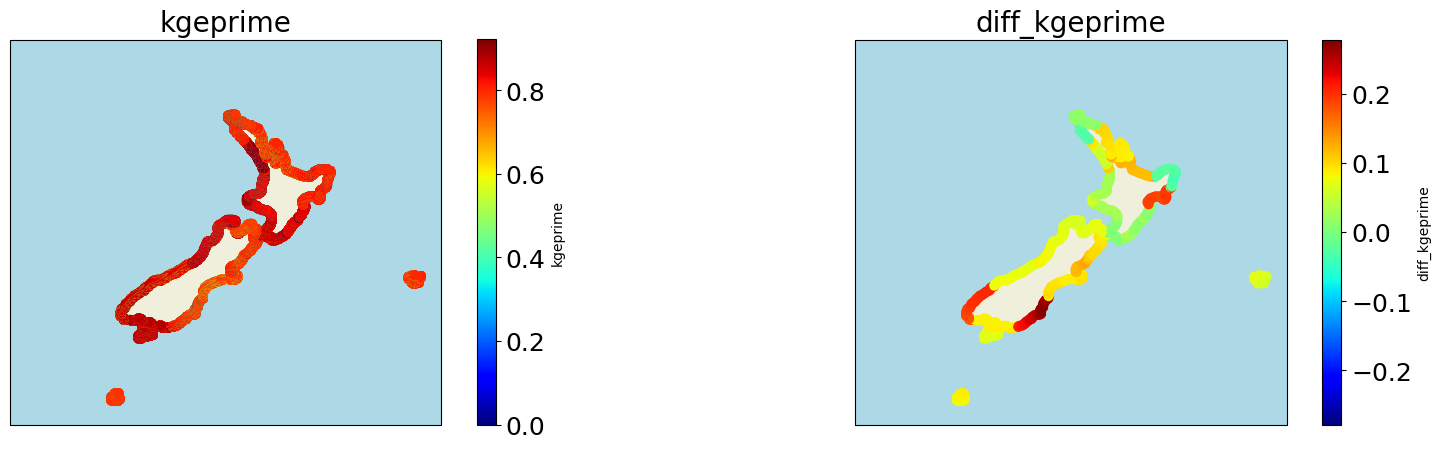

In [7]:
from matplotlib.colors import ListedColormap
ordered_mdarbf = ordered_mdarbf.assign({
    'diff_kgeprime': (('shore'),
        ordered_mdarbf.kgeprime.isel(experiment=23).values - \
            ordered_mdarbf.kgeprime.isel(experiment=14).values
    )
})
plot_stats(ordered_mdarbf,plot_stats=['kgeprime','diff_kgeprime'],
           cmap='jet', #ListedColormap(['pink','blue','green','orange','yellow'])
          )

In [8]:
ordered_mdarbf.perpcs[2::3,0],ordered_mdarbf.nsamples[2::3,0]

(<xarray.DataArray 'perpcs' (experiment: 8)>
 array([0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98])
 Coordinates:
   * experiment  (experiment) int64 2 5 8 11 14 17 20 23
     shore       int64 5
     site        int64 0,
 <xarray.DataArray 'nsamples' (experiment: 8)>
 array([  10.,   25.,   50.,  100.,  250.,  500., 1000., 1500.])
 Coordinates:
   * experiment  (experiment) int64 2 5 8 11 14 17 20 23
     shore       int64 5
     site        int64 0)

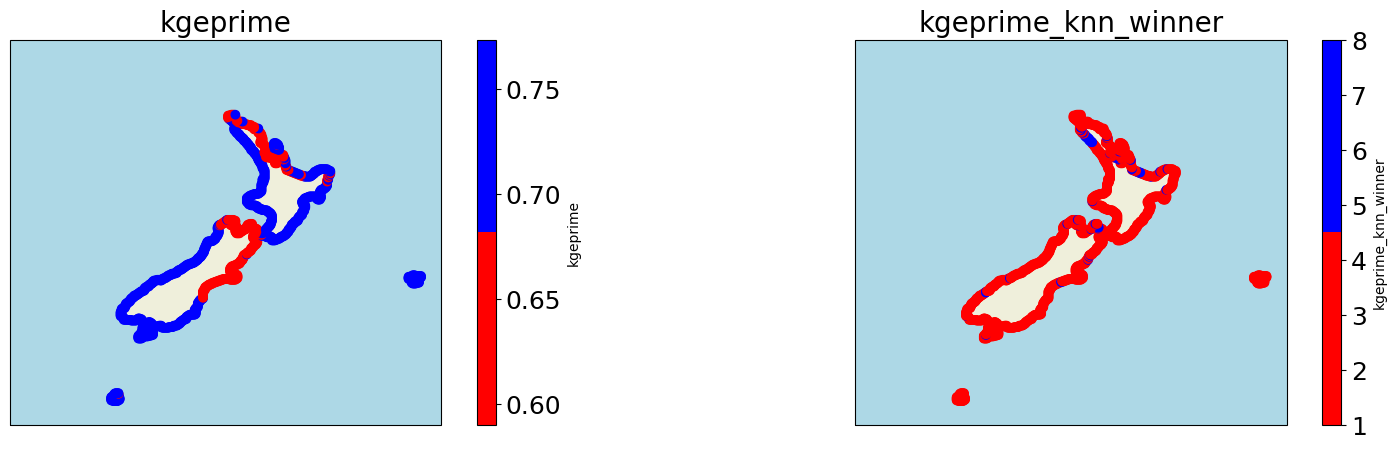

In [9]:
# knn winner
knn_all = knn_all.assign({
    'kgeprime_knn_winner': (('site'),np.argsort(
        np.concatenate([
            knn_all.isel(k_neighbors=nn).kgeprime.values.reshape(-1,1) for nn in range(49)
        ], axis=1), axis=1
    )[:,-1]),
    'longitude': (('site'),load_moana_hindcast().isel(
        site=data_plot.site).lon.values),
    'latitude': (('site'),load_moana_hindcast().isel(
        site=data_plot.site).lat.values)
})
plot_stats(knn_all.max(dim='k_neighbors'),plot_stats=['kgeprime','kgeprime_knn_winner'],
           cmap=ListedColormap(['red','blue']))

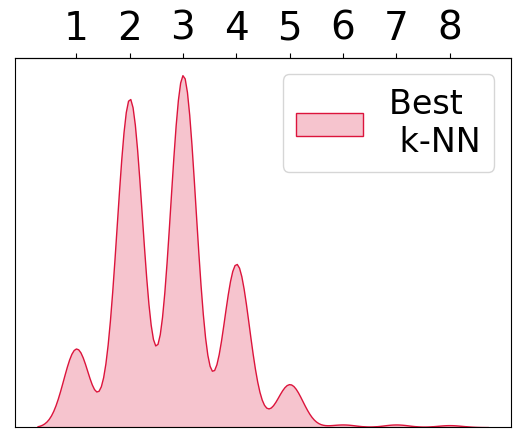

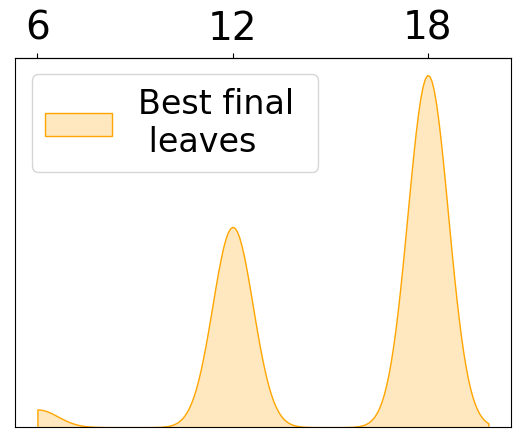

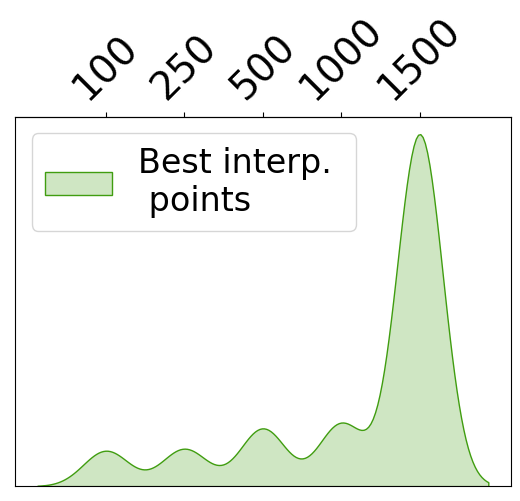

In [56]:
import seaborn as sns
fig, ax = plt.subplots()
sns.kdeplot(knn_all.kgeprime_knn_winner.values.reshape(-1), ax=ax,
            color='crimson',shade=True,clip=(0,50),label='Best \n k-NN')
sax = ax.secondary_xaxis('top')
sax.set_xticks([1,2,3,4,5,6,7,8])
sax.set_xticklabels([1,2,3,4,5,6,7,8],fontsize=28)
ax.legend(fontsize=24)
ax.set_xticks([]), ax.set_yticks([]), ax.set_ylabel('')
plt.show()
fig, ax = plt.subplots()
sns.kdeplot(np.argsort(
                np.concatenate([
                    xgboost_all.kgeprime.sel(md=6).values.reshape(-1,1),
                    xgboost_all.kgeprime.sel(md=12).values.reshape(-1,1),
                    xgboost_all.kgeprime.sel(md=18).values.reshape(-1,1)
                ], axis=1), axis=1
            )[:,-1], # best depth 
            # xgboost_all.kgeprime.sel(mss=0.02).values.reshape(-1),
            color='orange',shade=True,clip=(0,50),label='Best final \n leaves'
)
sax = ax.secondary_xaxis('top')
sax.set_xticks([0,1,2])
sax.set_xticklabels([6,12,18],fontsize=28)
ax.legend(fontsize=24,loc='upper left')
ax.set_xticks([]), ax.set_yticks([]), ax.set_ylabel('')
plt.show()
fig, ax = plt.subplots()
sns.kdeplot(ordered_mdarbf.kgeprime_exp_winner.values.reshape(-1),
            color='#409D10',shade=True,clip=(0,50),label='Best interp. \n points')
sax = ax.secondary_xaxis('top')
sax.set_xticks([4,5,6,7,8])
sax.set_xticklabels([100,250,500,1000,1500],fontsize=28,rotation=45)
ax.legend(fontsize=24,loc='upper left')
ax.set_xticks([]), ax.set_yticks([]), ax.set_ylabel('')
plt.show()

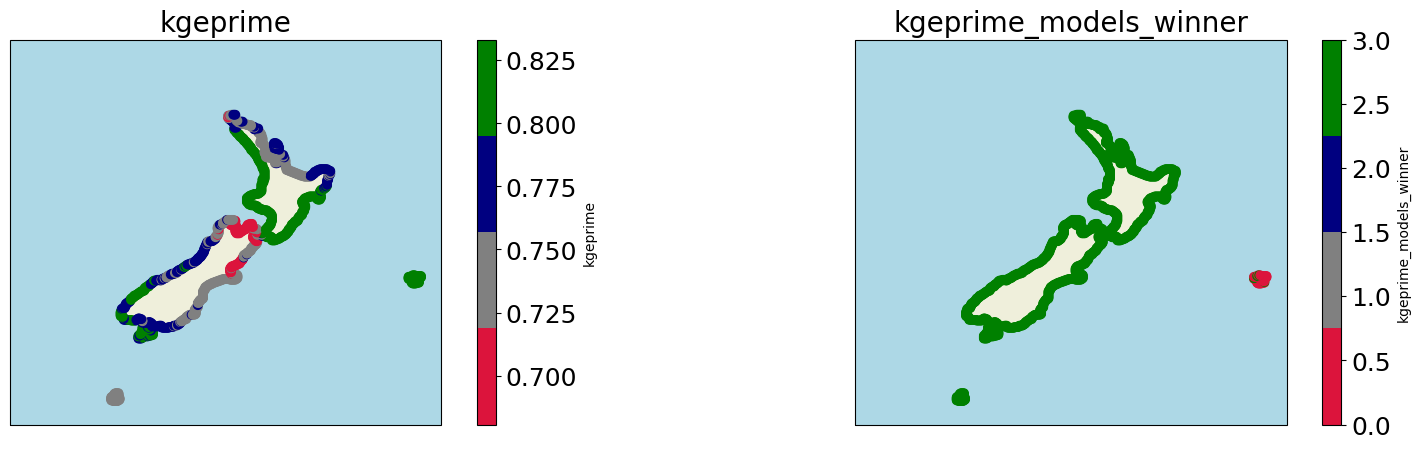

In [10]:
# linear models winner
linear_all = linear_all.assign({
    'kgeprime_models_winner': (('site'),np.argsort(
        np.concatenate([
            linear_all.kgeprime.values.reshape(-1,1),
            knn_all.kgeprime.max(dim='k_neighbors').values.reshape(-1,1),
            xgboost_all.kgeprime.max(dim=['md','mss']).values.reshape(-1,1),
            ordered_mdarbf.kgeprime.max(dim='experiment').values.reshape(-1,1)
        ], axis=1), axis=1
    )[:,-1]),
    'longitude': (('site'),load_moana_hindcast().isel(
        site=data_plot.site).lon.values),
    'latitude': (('site'),load_moana_hindcast().isel(
        site=data_plot.site).lat.values)
})
plot_stats(linear_all,plot_stats=['kgeprime','kgeprime_models_winner'],
           cmap=ListedColormap(['crimson','gray','navy','green']))

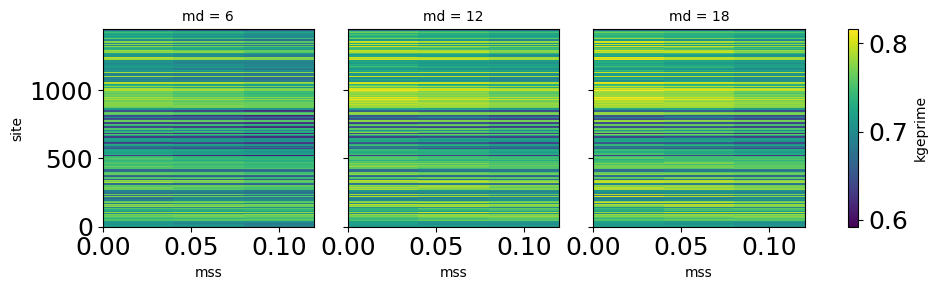

In [11]:
# xgboost play
xgboost_all.kgeprime.plot(col='md')
plt.show()

In [ ]:
pca_attrs = {
    'grad': [False,True], 
    'winds': [False,True],
    'tlapse': [1,2,3], # 1 equals to NO time delay 
    'tresample': ['6H','12H','1D'],
    'region': [('local',(1.5,1.5)),('local',(2.5,2.5)),(True,default_region_reduced)]
}
linear_attrs = {
    'tsize': [0.7], 'perpcs': [0.98]
}
knn_attrs = {
    'tsize': [0.7], 'perpcs': [0.98],
    'kneighs': ['best',3,6,9] # None calculates the optimum k-neighs
}
limits_metrics = {
    'bias': [-0.2,0.2],
    'si': [0.5,1.5],
    'rmse': [0.0,0.1],
    'pearson': [0.7,1.0],
    'spearman': [0.7,1.0]
}


def plot_results(model='linear',metric='rmse',var_1='grad',var_2='region',isite=2,
                 extra_1=0,extra_2=0,extra_3=0,extra_4=0,extra_5=0,extra_6=0):
    
    # TODO: add docstring
    
    # print(pca_attrs, linear_attrs)
    
    stats = linear_stats if model=='linear' else knn_stats
    model_attrs = linear_attrs if model=='linear' else knn_attrs
    
    var_1_values = pca_attrs[var_1] if var_1 in pca_attrs.keys() \
        else model_attrs[var_1]
    var_2_values = pca_attrs[var_2] if var_2 in pca_attrs.keys() \
        else model_attrs[var_2]    
    
    nrows, ncols = len(var_1_values), len(var_2_values)
    
    fig, axes = plt.subplots(
        nrows=nrows,ncols=ncols,figsize=(ncols*6,nrows*5),
        subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}
    )
    
    metrics_no_plot = []
    metrics_no_plot_values = [
        extra_1,extra_2,extra_3,extra_4,extra_5,extra_6
    ]
    for dim in stats.dims: metrics_no_plot.append(dim) \
        if dim!=var_1 and dim!=var_2 and dim!= 'site' else None   
    # default variables can be changed here
        
    metric_stats = stats[metric].isel(
        dict(zip(metrics_no_plot,metrics_no_plot_values[:len(metrics_no_plot)]))
    )
    max_model = np.argmax(metric_stats.values.reshape(
        len(metric_stats.site.values),-1
    ), axis=1)
    min_model = np.argmin(metric_stats.values.reshape(
        len(metric_stats.site.values),-1
    ), axis=1)
    
    i_model = 0
        
    for irow in range(nrows):
        for icol, ax in enumerate(axes[irow,:]):
                        
            ps = ax.scatter(
                x=locations.lon.values, y=locations.lat.values,
                c=metric_stats.isel(
                    {var_1:irow,var_2:icol}
                ).values, cmap='cool', zorder=200, s=100,
                vmin=metric_stats.min(), vmax=metric_stats.max(),
                transform=ccrs.PlateCarree()
            ) # metric values
            ax.text(
                x=162, # locations.lon.values[isite],
                y=-32, # locations.lat.values[isite],
                s=metric + ':  ' + str(metric_stats.isel(
                    {var_1:irow,var_2:icol,'site':isite}
                ).values)[:6], transform=ccrs.PlateCarree(),
                size=14 # change size if wanted
            ) # metric value in a desired location
            ax.scatter(
                x=locations.lon.values[isite],
                y=locations.lat.values[isite],
                s=300, transform=ccrs.PlateCarree(),
                zorder=150, c='yellow',edgecolors='red'
            ) # highlight desired location
            
            # highlight best models in screen
            sites_to_mark_max = np.where(max_model==i_model)[0]
            sites_to_mark_min = np.where(min_model==i_model)[0]
            
            if len(sites_to_mark_max):
                ax.scatter(
                    x=locations.lon.values[sites_to_mark_max],
                    y=locations.lat.values[sites_to_mark_max],
                    marker='*', c='white', s=80, edgecolors='white',
                    transform=ccrs.PlateCarree(), zorder=300
                )
            if len(sites_to_mark_min):
                ax.scatter(
                    x=locations.lon.values[sites_to_mark_min],
                    y=locations.lat.values[sites_to_mark_min],
                    marker='*', c='black', s=80, edgecolors='black',
                    transform=ccrs.PlateCarree(), zorder=300
                )
                
            ax.set_title(
                '{}: {} -- {}: {}'.format(
                    var_1, var_1_values[irow], 
                    var_2, var_2_values[icol]
                )
            ) # plot the subplots title
            
            i_model += 1
            
    plot_ccrs_nz(axes.flatten(),plot_labels=(False,None,None))
    for ax in axes.flatten(): ax.set_facecolor('lightblue')
    suptitle = metric.upper() + '\n {} \n'.format(
        dict(zip(metrics_no_plot,metrics_no_plot_values[:len(metrics_no_plot)]))
    ) # add default variables to suptitle
    fig.suptitle(suptitle,fontsize=20)
    cbar_ax = fig.add_axes([0.93,0.15,0.03,0.7])
    cb = fig.colorbar(ps,cax=cbar_ax,orientation='vertical')   
    
    plt.close()
    
    return fig
    
    
kw = dict(
    model=['linear','knn'],
    metric=list(limits_metrics.keys()),
    var_1=list(pca_attrs.keys())+list(linear_attrs.keys())+['kneighs'],
    var_2=list(pca_attrs.keys())+list(linear_attrs.keys())+['kneighs'],
    isite=range(10), # this is to modify desired locations print
    extra_1=range(3),extra_2=range(3),extra_3=range(3),
    extra_4=range(3),extra_5=range(3),extra_6=range(3)
)
i = pn.interact(plot_results,**kw)

In [ ]:
panel = pn.Column(
    pn.Row(
        pn.pane.Markdown('''
            ## Results of all the models are shown below
        ''')
    ),
    pn.Row(
        i[0][0],i[0][1],i[0][2],i[0][3],i[0][4]
    ),
    pn.Row(
        i[0][5],i[0][6],i[0][7],i[0][8],i[0][9]
    ),
    pn.Row(i[0][10], pn.pane.Markdown(
        ''' PCA attributes: {} and Models attributes: LINEAR: {} ---- KNN {} '''.format(
            pca_attrs, linear_attrs, knn_attrs
        )
    )),
    pn.Row(i[1][0])
)

panel.show() # launch interactive server